# Road Safety data
Source: https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

In [1]:
import os
import pandas as pd
import geopandas as gpd
import plotly
import plotly.express as px

# Change the current working directory, comment if data is in the same directory
#os.chdir('data')
# Print the current working directory
#print("Current working directory: {0}".format(os.getcwd()))

accident = pd.read_csv('dft-road-casualty-statistics-accident-last-5-years.csv', sep=",", low_memory=False)
casualty = pd.read_csv('dft-road-casualty-statistics-casualty-last-5-years.csv', sep=",", low_memory=False)
vehicle = pd.read_csv('dft-road-casualty-statistics-vehicle-last-5-years.csv', sep=",", low_memory=False)
xlsx = pd.read_excel('Road-Safety-Open-Dataset-Data-Guide.xlsx')

#accident.info(verbose = True, show_counts = True)
#casualty.info(verbose = True, show_counts = True)
#vehicle.info(verbose = True, show_counts = True)

# Joining datasets
df_merged = vehicle.merge(casualty, how='outer', left_on=['accident_index','accident_year','accident_reference','vehicle_reference'], right_on=['accident_index','accident_year','accident_reference','vehicle_reference'])
df_merged = df_merged.merge(accident, how='outer', left_on=['accident_index','accident_year','accident_reference'], right_on=['accident_index','accident_year','accident_reference'])
#df.info(verbose = True, show_counts = True)
# Which fields are null now?
#print(df_merged.isnull().sum().loc[lambda s: s > 0])
df_merged = df_merged.fillna(-1)
# The only table that contains null values is accident
#accident.isnull().sum().loc[lambda s: s > 0]
print("Data from " + str(accident['date'].min()) + " to " + str(accident['date'].max()))       

Data from 01/01/2016 to 31/12/2020


In [2]:
# Filtering relevant fields
df_filtered = df_merged[['accident_year',
    'longitude', 'latitude', 'local_authority_ons_district', 
    'day_of_week', 'time',
    
    # Driver
    'vehicle_type', 'propulsion_code',
    'vehicle_manoeuvre', 'junction_location',
    'sex_of_driver', 'age_band_of_driver', 
    
    # Casualty
    'sex_of_casualty', 'age_band_of_casualty',
    'accident_severity', 'casualty_severity', 
    'casualty_class', 'casualty_type', 'car_passenger',     
    'casualty_home_area_type', 
    
    # Road
    'road_type', 'first_road_class', 'second_road_class',
    'junction_detail', 'junction_control',
    'urban_or_rural_area', 
    'did_police_officer_attend_scene_of_accident',
    'age_of_driver', 'age_of_vehicle', 'age_of_casualty', 'number_of_vehicles', 'number_of_casualties', 'speed_limit', 'generic_make_model' #needs data prep
    # 'accident_index', 'accident_reference','vehicle_reference', 'casualty_reference', # indexes
    #'vehicle_direction_from', 'vehicle_direction_to', 'driver_imd_decile', 'casualty_imd_decile', # limited applicability
    # 'driver_home_area_type', # limited applicability
    # 'local_authority_district', 'local_authority_highway', 'police_force', 'lsoa_of_accident_location' # Repeated
    # 'date', 
]]

In [3]:
# Importing geographical data
# Data source of geopgraphical data:
#https://mangomap.com/pgager2/maps/36876/United-Kingdom-Administrative-Boundaries-for-download-#
#https://ukdataservice.ac.uk/learning-hub/census/
#https://borders.ukdataservice.ac.uk/easy_download.html
#gdf = gpd.read_file("infuse_dist_lyr_2011.shp")
#gdf = gdf[['geo_code', 'name', 'geometry']]
gdf = gpd.read_file("UK_DISTRICTS_COUNTIES_CENSUS2011.shp")
gdf = gdf[['LAD11CD','LAD11NM','geometry']]
gdf.columns = ['geo_code', 'name', 'geometry']
#gdf.explore(legend=False)

# Finding Centroid
crs = 'GCS_WGS_1984'
gdf.to_crs(crs, inplace = True)
gdf.set_crs(crs, inplace = True)
gdf['centroid'] = gdf.centroid
gdf['centroid'] = gdf['centroid'].to_crs(crs)
gdf['centroid'] = gdf['centroid'].set_crs(crs)
gdf['lon'] = gdf['centroid'].x
gdf['lat'] = gdf['centroid'].y

C:\Users\camil\AppData\Local\Temp\ipykernel_16304\1677070671.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.centroid


In [4]:
def group_by_field(field_name = 'number_of_casualties', df_filtered = df_filtered, gdf = gdf):
    ''' Sum of casualties grouped by district and field_name
    '''
    # Grouping districts by field_name
    df_group = df_filtered.groupby(['local_authority_ons_district'])[field_name].sum().to_frame()

    # Adding geografical coordinates
    df_group = df_group.merge(gdf, how='outer', left_on=['local_authority_ons_district'], right_on=['geo_code']).dropna()

    return df_group

geo_df = group_by_field('number_of_casualties', df_filtered, gdf)


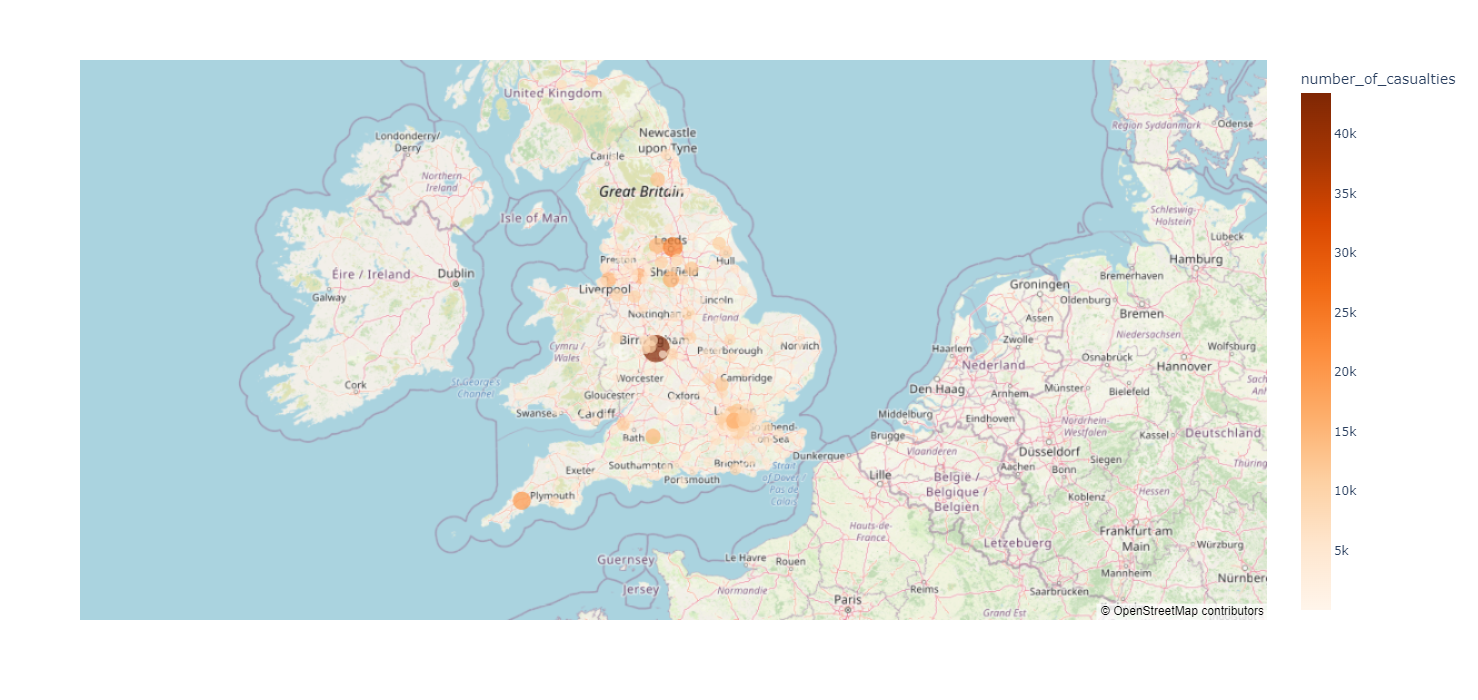

In [5]:
field_name = 'number_of_casualties'

fig = px.scatter_mapbox(geo_df, lat="lat", lon="lon", color=field_name, size=field_name, mapbox_style = "open-street-map",
                          height = 700, zoom = 5, hover_name ='name', hover_data=[field_name], color_continuous_scale=plotly.colors.sequential.Oranges)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

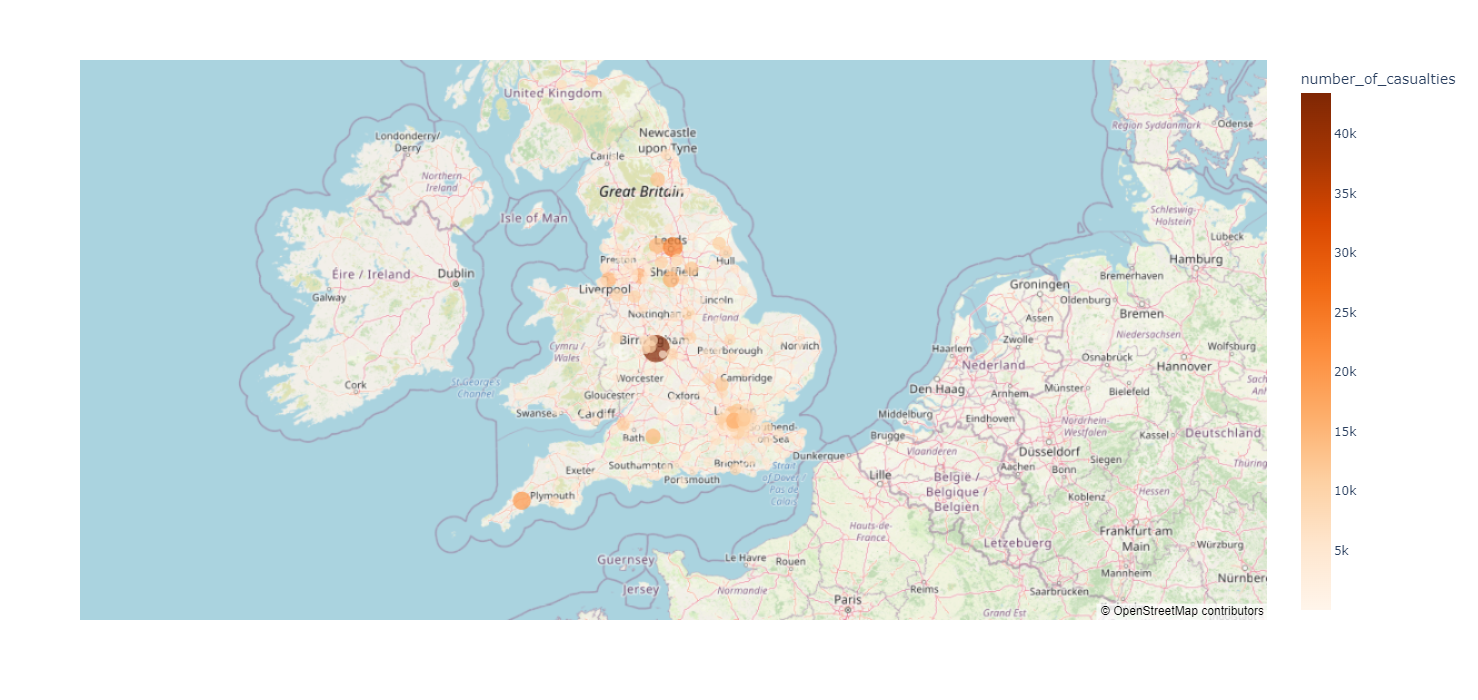

In [6]:
fig

In [7]:
import matplotlib.pylab as plt
import collections
import plotly.express as px

def make_frequency_df(dff = df_filtered, field_name = 'weather_conditions', categorical = True, xlsx=xlsx, percentage = False):
    ''' Makes a horizontal bar plot in order of frequency for categorical = True
    Vertical plot in order of index if categorical = False
    xlsx is the file containing the corespondence of names
    
    percentage = True to show values as percentage of the total
    '''
    # frequency
    frequencies = pd.DataFrame.from_dict(collections.Counter(dff[field_name]), orient='index')

    # to read the xls with the correspondencies
    xlsx_df = xlsx[xlsx['field name'] == field_name][['code/format','label']].set_index('code/format').drop_duplicates()
    if categorical:       
        frequencies = pd.concat([frequencies,xlsx_df], axis=1).sort_values(by=0,ascending=True).dropna()        
    else:
        frequencies = pd.concat([frequencies,xlsx_df], axis=1).sort_index().dropna()
    
    frequencies = frequencies.rename(columns={0: "Frequency", "label": field_name})
    # Return df with a percetage of the total
    if percentage:
        frequencies['Frequency'] = round(frequencies['Frequency']/frequencies['Frequency'].sum()*100,0)
    
    # Graph
    if categorical:           
        fig = px.bar(frequencies, x='Frequency', y=field_name, title=field_name)
    else:
        fig = px.bar(frequencies, x=field_name, y='Frequency', title=field_name)
    
    return frequencies, fig

## Dash with options

In [39]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

#app = JupyterDash(__name__)
app = JupyterDash(external_stylesheets = [dbc.themes.BOOTSTRAP])
df = df_filtered

app.layout = html.Div(children=[
    html.H1('Road Casualties'),
    
    html.Div([
        # Left
        html.Div([
            dcc.Dropdown(
                ['road_type','junction_detail','junction_location','did_police_officer_attend_scene_of_accident','urban_or_rural_area', 'driver_home_area_type','casualty_home_area_type',
                 'propulsion_code','vehicle_type','vehicle_manoeuvre',
                 'sex_of_driver',
                'casualty_class','age_band_of_casualty','sex_of_casualty','casualty_severity','casualty_type'],
                'road_type',
                id='parameter'),
            dcc.RadioItems(
                ['Totals', 'Percentage'],
                'Percentage',
                id='yaxis-type',
                inline=True,
                inputStyle={"margin-left": "20px"}),
        ], style={'width': '48%', 'float': 'left', 'display': 'inline-block'}),

        # Right
        html.Div([
            html.Label('Accident severity'),
            dcc.Checklist(['Fatal','Serious','Slight'],
                      ['Fatal','Serious','Slight'],
                      id = 'accident_severity_choice',
                      inline=True,
                inputStyle={"margin-left": "20px"}),
            
            html.Label('Type of Vehicle'),
            dcc.Checklist(['EV','Non-Ev'],
                          ['EV','Non-Ev'],
                          id = 'ev',
                          inline=True,
                          inputStyle={"margin-left": "20px"},),
            
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'}),

    ], className='row'),
    

    
    html.Div([  
        html.Div([
            dcc.Graph(id='map')
        ], style={'width': '47%', 'float': 'left', 'display': 'inline-block'}),

        html.Div([
            dcc.Graph(id='indicator-graphic')
        ], style={'width': '47%', 'float': 'right', 'display': 'inline-block'}),
    ], className='row'),  


    html.Div([
        dcc.Slider(
            df['accident_year'].min(),
            df['accident_year'].max(),
            step=None,
            id='year--slider',
            value=df['accident_year'].max(),
            marks={str(year): str(year) for year in df['accident_year'].unique()}),
    ], className='row'),
    
], style={'margin-left': '2vw', 'margin-top': '2vw'})       

        
@app.callback(
    Output('indicator-graphic','figure'),
    Output('map','figure'),
    Input('accident_severity_choice', 'value'),
    Input('parameter', 'value'),
    Input('yaxis-type', 'value'),
    Input('year--slider', 'value'))

def update_graph(accident_severity_chosen, field_name, yaxis_type, year_value): 
    categorical = True
    percentage = False

    dff = df_filtered[df_filtered['accident_year'] == year_value]
    
    #make_frequency_df
    frequencies = pd.DataFrame.from_dict(collections.Counter(dff[field_name]), orient='index')

    # to read the xls with the correspondencies
    if categorical:
        xlsx = pd.read_excel('Road-Safety-Open-Dataset-Data-Guide.xlsx')
        xlsx = xlsx[xlsx['field name'] == field_name][['code/format','label']].set_index('code/format').drop_duplicates()
        frequencies = pd.concat([frequencies,xlsx], axis=1).sort_values(by=0,ascending=True).dropna()
    else:
        frequencies = frequencies.sort_index()
    
    # Return df with a percetage of the total
    if percentage:
        frequencies[0] = round(frequencies[0]/frequencies[0].sum()*100,0)
    
    frequencies = frequencies.rename(columns={0: "Frequency", "label": field_name})

    fig = px.bar(frequencies, x='Frequency', y=field_name, orientation='h')#, title=field_name)

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')
    
    #Map
    field_name = 'number_of_casualties'

    map_full = px.scatter_mapbox(geo_df, lat="lat", lon="lon", color=field_name, size=field_name, mapbox_style = "open-street-map",
                          height = 700, zoom = 5, hover_name ='name', hover_data=[field_name], color_continuous_scale=plotly.colors.sequential.Oranges)
    

    
    return fig,map_full 

if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


D:\Programs\anaconda3\lib\site-packages\jupyter_dash\jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.

D:\Programs\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



['Fatal', 'Serious', 'Slight']


D:\Programs\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



['Fatal', 'Serious', 'Slight']
